<a href="https://colab.research.google.com/github/takeshinishimura/Cooperative/blob/main/09_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keyring
!pip install japanize-matplotlib
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import requests
import keyring
import json
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [3]:
# APIのエンドポイントとパラメーターを指定
url = 'https://api.e-stat.go.jp/rest/3.0/app/getSimpleStatsData'
params = {
#   'appId': keyring.get_password('e-stat', 'username'),
    'appId': 'ここにAPI ID',
    'statsDataId': '0002003132',
    'sectionHeaderFlg': 2
}

In [4]:
# APIにリクエストを送信し，レスポンスを取得
response = requests.get(url, params=params)
if response.status_code != 200:
    print('Failed to get data from e-Stat API')

df = pd.read_csv(io.StringIO(response.text), header=0)
df

,cat01_code,(R006-02-2-002)都道府県,cat02_code,(R006-03-1-001)総括表,unit,value,annotation
0,1,北海道,1001,出資組合（第２表）_総合農協,件,109,NaN
1,1,北海道,1002,出資組合（第２表）_総合農協_業務代理農協,件,3,※4
2,1,北海道,1003,出資組合（第２表）_総合農協_うち共済事業を行う農協,件,104,NaN
3,1,北海道,1004,出資組合（第２表）_総合農協_うち共済事業を行う農協_業務代理農協,件,3,※4
4,1,北海道,1005,出資組合（第２表）_一般農協,件,4,NaN
...,...,...,...,...,...,...,...
1887,57,全国計,1031,（参考１）出資組合と非出資組合の計（専門農協、業種別）_園芸特産,件,166,NaN
1888,57,全国計,1032,（参考１）出資組合と非出資組合の計（専門農協、業種別）_農村工業,件,14,NaN
1889,57,全国計,1033,（参考１）出資組合と非出資組合の計（専門農協、業種別）_農事放送,件,19,NaN
1890,57,全国計,1034,（参考１）出資組合と非出資組合の計（専門農協、業種別）_その他,件,100,NaN


In [5]:
df2 = df.copy()
df2.columns = df2.columns.str.replace(r'\(.+\)', '', regex=True)
df2.loc[df2['value'] == '-', 'value'] = np.nan
df2['value'] = pd.to_numeric(df2['value'], errors='coerce')

In [6]:
pref = df2['都道府県'].unique()
pref = np.array([p for p in pref if not any(e in p for e in ['計', '２', '全'])])

In [7]:
df2['総括表'] = pd.Categorical(df2['総括表'])
df2_pivot = df2.pivot(index='都道府県', columns='総括表', values='value').reset_index()
df2_pivot.index = df2_pivot['都道府県']
df2_pivot = df2_pivot.loc[pref, :]

In [8]:
dfja2 = df2_pivot.loc[:, ['都道府県'] + [col for col in df2_pivot.columns if col.startswith('出資組合（第２表）_')]]
dfja3 = df2_pivot.loc[:, ['都道府県'] + [col for col in df2_pivot.columns if col.startswith('非出資組合（第３表）_')]]
dfref1 = df2_pivot.loc[:, ['都道府県'] + [col for col in df2_pivot.columns if col.startswith('（参考１）出資組合と非出資組合の計（専門農協、業種別）_')]]

In [9]:
dfja2.columns = dfja2.columns.str.replace('出資組合（第２表）_', '', regex=True)
dfja3.columns = dfja3.columns.str.replace('非出資組合（第３表）_', '', regex=True)
dfref1.columns = dfref1.columns.str.replace('参考１）出資組合と非出資組合の計（専門農協、業種別）_', '', regex=True)

In [10]:
dfja2

総括表,都道府県,その他,一般農協,出資組合計,園芸特産,牧野管理,畜産,総合農協,総合農協_うち共済事業を行う農協,総合農協_うち共済事業を行う農協_業務代理農協,総合農協_業務代理農協,農事放送,農村工業,酪農,養鶏
都道府県,,,,,,,,,,,,,,,
北海道,北海道,2.0,4.0,135.0,1.0,1.0,9.0,109.0,104.0,3.0,3.0,NaN,2.0,5.0,2.0
青森,青森,1.0,6.0,37.0,NaN,8.0,10.0,10.0,10.0,NaN,NaN,NaN,1.0,NaN,1.0
岩手,岩手,1.0,NaN,31.0,3.0,12.0,3.0,9.0,7.0,NaN,NaN,NaN,1.0,2.0,NaN
宮城,宮城,2.0,NaN,16.0,NaN,1.0,NaN,10.0,10.0,NaN,NaN,NaN,NaN,2.0,1.0
秋田,秋田,NaN,NaN,21.0,2.0,NaN,3.0,13.0,13.0,NaN,NaN,NaN,NaN,3.0,NaN
山形,山形,NaN,NaN,18.0,1.0,NaN,NaN,15.0,15.0,NaN,NaN,NaN,NaN,2.0,NaN
福島,福島,2.0,1.0,12.0,2.0,1.0,NaN,5.0,5.0,NaN,NaN,NaN,NaN,1.0,NaN
茨城,茨城,1.0,NaN,30.0,5.0,NaN,2.0,17.0,17.0,NaN,NaN,NaN,NaN,5.0,NaN
栃木,栃木,NaN,2.0,19.0,1.0,NaN,NaN,12.0,10.0,NaN,NaN,NaN,NaN,4.0,NaN


<BarContainer object of 47 artists>

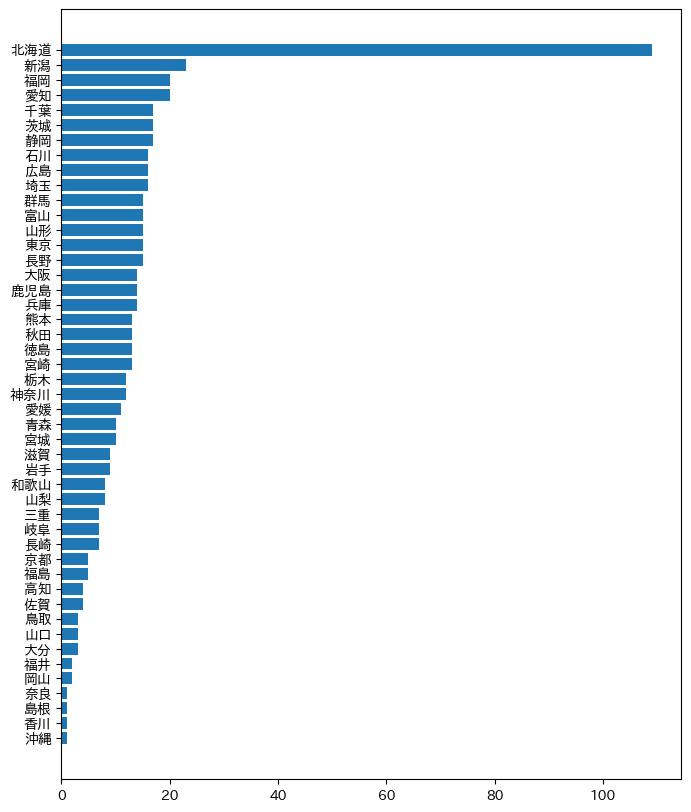

In [11]:
dfja2_2 = dfja2.sort_values('総合農協')
plt.figure(figsize=(8, 10))
plt.barh(dfja2_2['都道府県'], dfja2_2['総合農協'])

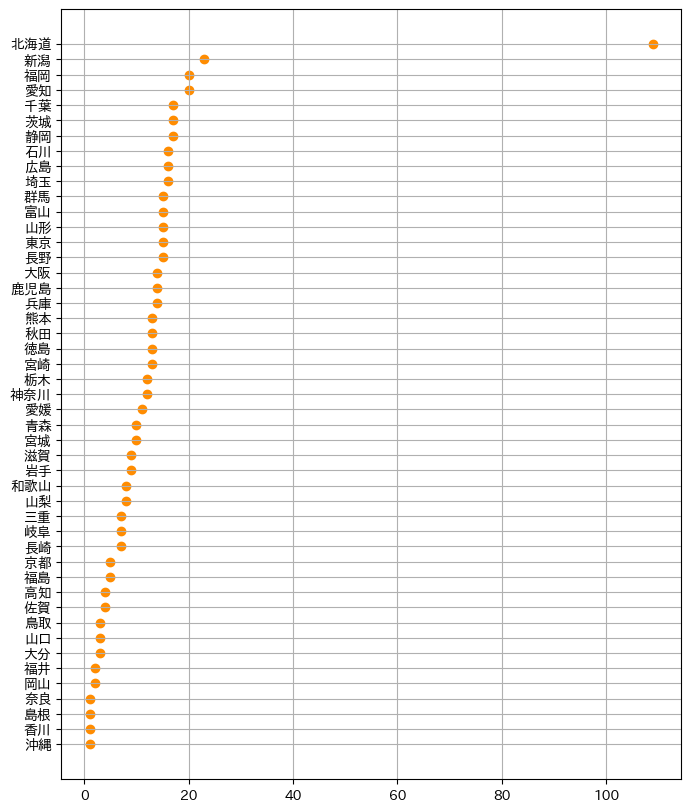

In [12]:
plt.figure(figsize=(8, 10))
plt.scatter(dfja2_2['総合農協'], dfja2_2['都道府県'], c='darkorange')
plt.grid()

In [13]:
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import urllib.request
import zipfile

In [14]:
url = "https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces_lakes.zip"
filename = "ne_10m_admin_1_states_provinces_lakes.zip"
urllib.request.urlretrieve(url, filename)

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()

In [15]:
japan_map = gpd.read_file("ne_10m_admin_1_states_provinces_lakes.shp")
japan_map = japan_map[japan_map["iso_a2"] == "JP"]
japan_map = japan_map.rename(columns={"name_ja": "pref"})

In [16]:
dfja2['pref'] = dfja2['都道府県']
pref_names = ["北海道", "東京", "京都", "大阪"]
suffixes = ["", "都", "府", "府"]
dfja2["pref"] = dfja2["pref"].apply(lambda x: x + suffixes[pref_names.index(x)] if x in pref_names else x + "県")

pref_dict = {
    '北海道': 'JP-01', '青森県': 'JP-02', '岩手県': 'JP-03', '宮城県': 'JP-04', '秋田県': 'JP-05',
    '山形県': 'JP-06', '福島県': 'JP-07', '茨城県': 'JP-08', '栃木県': 'JP-09', '群馬県': 'JP-10',
    '埼玉県': 'JP-11', '千葉県': 'JP-12', '東京都': 'JP-13', '神奈川県': 'JP-14', '新潟県': 'JP-15',
    '富山県': 'JP-16', '石川県': 'JP-17', '福井県': 'JP-18', '山梨県': 'JP-19', '長野県': 'JP-20',
    '岐阜県': 'JP-21', '静岡県': 'JP-22', '愛知県': 'JP-23', '三重県': 'JP-24', '滋賀県': 'JP-25',
    '京都府': 'JP-26', '大阪府': 'JP-27', '兵庫県': 'JP-28', '奈良県': 'JP-29', '和歌山県': 'JP-30',
    '鳥取県': 'JP-31', '島根県': 'JP-32', '岡山県': 'JP-33', '広島県': 'JP-34', '山口県': 'JP-35',
    '徳島県': 'JP-36', '香川県': 'JP-37', '愛媛県': 'JP-38', '高知県': 'JP-39', '福岡県': 'JP-40',
    '佐賀県': 'JP-41', '長崎県': 'JP-42', '熊本県': 'JP-43', '大分県': 'JP-44', '宮崎県': 'JP-45',
    '鹿児島県': 'JP-46', '沖縄県': 'JP-47'
}
dfja2['iso_3166_2'] = dfja2['pref'].map(pref_dict)

In [17]:
japan_map2 = japan_map.merge(dfja2, on="iso_3166_2", how="left")

cmap = LinearSegmentedColormap.from_list("", [(0, "#f7fcf5"), (1, "#00441b")])

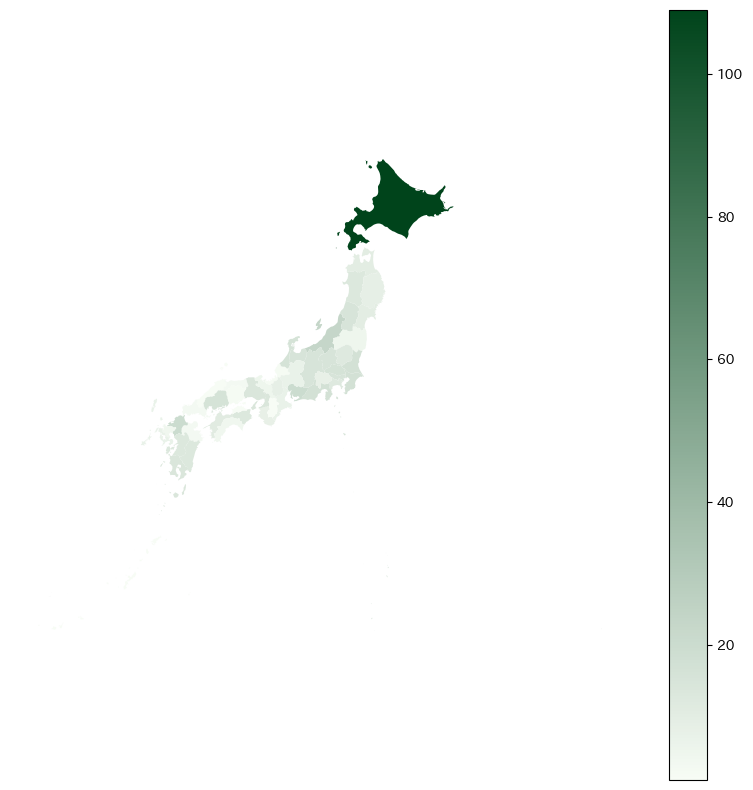

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
japan_map2.plot(column='総合農協', ax=ax, cmap=cmap, legend=True)
ax.set_axis_off()